## IRIS and MNIST classification using TTN and MERA

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import os, csv

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from sklearn.model_selection import train_test_split
# TODO: mottonen will be changed to its subpackage and the relative path will change
from mottonen import encode_classical_datapoint

seed = 42
np.random.seed(seed)

In [2]:
!export IRIS_URL="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" && curl $IRIS_URL > iris.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4551  100  4551    0     0  17639      0 --:--:-- --:--:-- --:--:-- 17639


## Data Encoding

### IRIS data set encoding
We standardize the data and make this a binary classification problem.

1. First we will fetch the IRIS dataset
2. Only select the datagrams with labels 1 or 2, with label 1 as 0 and 2 as 1
3. Standadize the data so that each dimension is only $[0, \frac{\pi}{2}]$
4. Use Mottonen[] to generate the quantum data encoding circuits using qubit encoding

### Standardize the data

In [2]:
class IrisData:
    def __init__(self):
        return
    
    def _get_binary_dataset(self):
        with open('./iris.csv') as csv_file:
            reader = csv.reader(csv_file, delimiter=',')
            rows = list(reader)
            rows.pop()
            data = [row for row in rows if row[4] != 'Iris-virginica']
            for datum in data:
                if datum[4] == 'Iris-setosa':
                    datum[4] = 1.0
                else:
                    datum[4] = -1.0
            data = np.array(data, dtype=np.float32)
            labels = data[:,4]
            data = data[:,:4]
            data = data.reshape(100, 4, 1)
            data = (data-np.min(data))/(np.max(data)-np.min(data))
            data = np.concatenate((np.cos(np.pi*0.5*data), np.sin(np.pi*0.5*data)), axis=2)
            return data, labels
        
    def get_binary_test_train_split(self):
        data, labels = self._get_binary_dataset()
        _data = []
        # only reason for using GridQubit is because the serializer in
        # cirq for converting it into a tensor only works for GridQubits
        # in 'this' cirq release.
        qubits = cirq.GridQubit.rect(1,4)
        for idx in range(data.shape[0]):
            datapoint = data[idx]
            _circuit = cirq.Circuit()
            for i in range(4):
                _circuit.append(encode_classical_datapoint(np.array(datapoint[i][::-1]), [qubits[i]]))
            _data.append(_circuit)
        X_train, X_test, y_train, y_test = train_test_split(_data, labels, test_size=0.1, random_state=seed)
        X_train, X_test = tfq.convert_to_tensor(X_train), tfq.convert_to_tensor(X_test)

        return X_train, X_test, y_train, y_test

In [3]:
iris_data = IrisData()
X_train, X_test, y_train, y_test = iris_data.get_binary_test_train_split()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(90,) (10,) (90,) (10,)


## TTN Model

### Model Definitions

In [16]:
class TTNBinaryClassificationModel():
    def __init__(self):
        iris_data = IrisData()
        self.iris_X_train, self.iris_X_test, self.iris_y_train, self.iris_y_test =  iris_data.get_binary_test_train_split()
        return
    
    def _ttn_real_unitary(self, qubits, symbols):
        circuit = cirq.Circuit()
        circuit.append(cirq.ry(symbols[0])(qubits[0]))
        circuit.append(cirq.ry(symbols[1])(qubits[1]))
        circuit.append(cirq.CNOT(qubits[0], qubits[1]))
        return circuit
    
    def _ttn_model_iris(self, qubits):
        symbols, circuit = sympy.symbols('x0:6'), cirq.Circuit()
        circuit.append(self._ttn_real_unitary(qubits[:2], symbols[:2]))
        circuit.append(self._ttn_real_unitary(qubits[2:4], symbols[2:4]))
        circuit.append(self._ttn_real_unitary(qubits[1:3], symbols[4:6]))
        return circuit, symbols
    
    @tf.function
    def _custom_accuracy(self, y_true, y_pred):
        y_true = tf.squeeze(y_true)
        y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else -1.0, y_pred)
        return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))
    
    def _iris_model_compile(self):
        # declare qubits and readout operators
        cluster_state_bits = cirq.GridQubit.rect(1, 4)
        readout_operators = cirq.Z(cluster_state_bits[3])

        iris_ttn_model, symbols = self._ttn_model_iris(cluster_state_bits)
        iris_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        iris_pqc = tfq.layers.PQC(iris_ttn_model, readout_operators, initializer=tf.keras.initializers.RandomUniform(-np.pi, np.pi))
        iris_measurement_output = iris_pqc(iris_data_input)

        iris_model = tf.keras.Model(inputs=iris_data_input, outputs=iris_measurement_output)
        iris_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
                           loss=tf.keras.losses.MSE, metrics=[self._custom_accuracy])
        tf.keras.utils.plot_model(iris_model, show_shapes=True, dpi=70)
        
        self.iris_model = iris_model
    
    def iris_model_fit(self):
        self._iris_model_compile()
        history = self.iris_model.fit(x=X_train, y=y_train, epochs=100, verbose=0)
        plt.plot(history.history['loss'])
        plt.title("Binary Classification for IRIS data set")
        plt.xlabel("Iterations")
        plt.ylabel("Error in classification")
        plt.show()
        print("Final loss value:")
        print(history.history["loss"][-1])
        
    def iris_model_accuracy(self):
        predicted = self.iris_model.predict(self.iris_X_test)
        predicted[predicted >= 0] = 1.0
        predicted[predicted < 0] = -1.0
        iris_y_test = np.expand_dims(self.iris_y_test, axis=1)
        print(predicted.shape, iris_y_test.shape)
        return (1 - np.mean(np.abs(predicted-iris_y_test))) * 100

In [17]:
ttn_binary_classification_model = TTNBinaryClassificationModel()

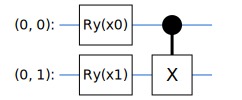

In [18]:
SVGCircuit(ttn_binary_classification_model._ttn_real_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:2')))

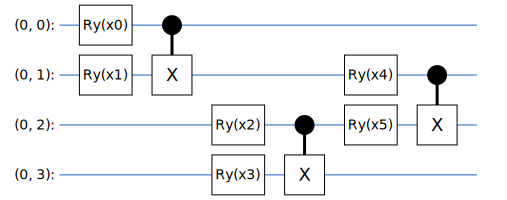

In [19]:
SVGCircuit(ttn_binary_classification_model._ttn_model_iris(cirq.GridQubit.rect(1,4))[0])

### Training

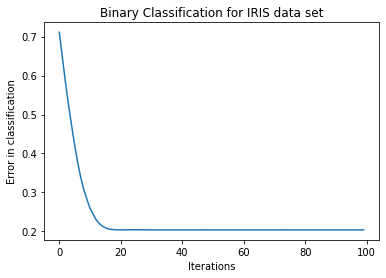

Final loss value:
0.2038562516371409


In [20]:
ttn_binary_classification_model.iris_model_fit()

In [21]:
ttn_binary_classification_model.iris_model_accuracy()

(10, 1) (10, 1)


100.0